In [81]:
import os
import pandas as pd
import numpy as np
import random
import operator
from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from skimage.feature import local_binary_pattern
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
TEST_SET_SIZE = 0.3 # 1 - TEST_SET_SIZE (70%) - training set, TEST_SET_SIZE (30%) testing set
VAL_SET_SIZE = 0.5  # 50% of testing set, it means
                    # TEST_SET_SIZE / 2 (15%) - testing set, TEST_SET_SIZE / 2 (15%) validation set

In [3]:
def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0


In [4]:
class DatasetSplittingType(Enum):
    kFOLD= 0
    TRAIN_TEST = 1
    TRAIN_VAL_TEST = 2

In [5]:
class HemorrageDataset:
    def __init__(self, diagnoseCsvPath, folderPath):
        self.__diagnoseCSV = pd.read_csv(diagnoseCsvPath)
        self.__pathToWholeFolder = folderPath
        self.__trainDataForLoading = []
        self.__trainLabelsForLoading = []
        self.__testDataForLoading = []
        self.__testLabelsForLoading = []
        self.__valDataForLoading = []
        self.__valLabelsForLoading = []
        self.__kFoldDataForLoading = []
        self.__kFoldLabelsForLoading = []

    def __kFoldSplitting(self, k, sickCases, healthyCases):
        healthyLabels = [1 for i in range(len(healthyCases))]
        sickLabels = [0 for i in range(len(sickCases))]
        allCases = healthyCases + sickCases
        allLabels = healthyLabels + sickLabels
        allCases, allLabels = shuffle(allCases, allLabels)

        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
        for train_index, test_index in skf.split(allCases, allLabels):
            trainNumbersFold, testNumbersFold = operator.itemgetter(*train_index)(allCases), operator.itemgetter(*test_index)(allCases)
            trainData, trainLabels = self.__prepareDataSavingPatienNumberAndSlice(trainNumbersFold)
            testData, testLabels = self.__prepareDataSavingPatienNumberAndSlice(testNumbersFold)
            self.__kFoldDataForLoading.append([trainData, testData])
            self.__kFoldLabelsForLoading.append([trainLabels, testLabels])


    def __subsetSplitting(self, sickCases, healthyCases):
        trainHealthyPatientsNumbers, testHealthyPatientsNumbers = train_test_split(healthyCases, test_size=TEST_SET_SIZE,random_state=25, shuffle=True)
        testHealthyPatientsNumbers, valHealthyPatientsNumbers = train_test_split(testHealthyPatientsNumbers, test_size=VAL_SET_SIZE,random_state=25, shuffle=True)
        trainSickPatientsNumbers, testSickPatientsNumbers = train_test_split(sickCases, test_size=TEST_SET_SIZE,random_state=25, shuffle=True)
        testSickPatientsNumbers, valSickPatientsNumbers = train_test_split(testSickPatientsNumbers, test_size=VAL_SET_SIZE,random_state=25, shuffle=True)

        trainCases = trainHealthyPatientsNumbers + trainSickPatientsNumbers
        trainCases = random.sample(trainCases, len(trainCases))
        testCases = testHealthyPatientsNumbers + testSickPatientsNumbers
        testCases = random.sample(testCases, len(testCases))
        valCases = valHealthyPatientsNumbers + valSickPatientsNumbers
        valCases = random.sample(valCases, len(valCases))
        return trainCases, testCases, valCases

    def __distinquishHealthyAndSickCases(self):
        sickCases = []
        healthyCases = []
        for patientNum in np.unique(self.__diagnoseCSV['PatientNumber']):
            isSick = self.__diagnoseCSV[(self.__diagnoseCSV['PatientNumber'] == patientNum)].Has_Hemorrhage.sum()
            if isSick > 0:
                sickCases.append(patientNum)
            else:
                healthyCases.append(patientNum)

        return healthyCases, sickCases

    def __prepareDataSavingPatienNumberAndSlice(self, chosenSet):
        data = []
        labels = []
        for patientNum in chosenSet:
            for sliceNum in np.unique(self.__diagnoseCSV.loc[(self.__diagnoseCSV['PatientNumber'] == patientNum)]['SliceNumber']):
                diagnose = self.__diagnoseCSV.loc[(self.__diagnoseCSV['PatientNumber'] == patientNum)
                                        & (self.__diagnoseCSV['SliceNumber'] == sliceNum)]['Has_Hemorrhage'].values[0]
                data.append((patientNum, sliceNum))
                labels.append(diagnose)

        return data, labels

    def splitDatasetBasedOnPatientsCases(self, splittingType, kFold = 0):
         healthyPatientsNumbers, sickPatientsNumbers = self.__distinquishHealthyAndSickCases()

         if(splittingType == DatasetSplittingType.kFOLD):
             self.__kFoldSplitting(kFold, sickPatientsNumbers, healthyPatientsNumbers)
         elif ((splittingType == DatasetSplittingType.TRAIN_VAL_TEST) or (splittingType == DatasetSplittingType.TRAIN_TEST)):
             trainSubset, testSubset, valSubset = self.__subsetSplitting(sickPatientsNumbers, healthyPatientsNumbers)
             self.__trainDataForLoading, self.__trainLabelsForLoading = self.__prepareDataSavingPatienNumberAndSlice(trainSubset)
             self.__testDataForLoading, self.__testLabelsForLoading = self.__prepareDataSavingPatienNumberAndSlice(testSubset)
             self.__valDataForLoading, self.__valLabelsForLoading = self.__prepareDataSavingPatienNumberAndSlice(valSubset)

             if(splittingType == DatasetSplittingType.TRAIN_TEST):
                 self.__testDataForLoading += self.__valDataForLoading
                 self.__testLabelsForLoading += self.__valLabelsForLoading
                 self.__valDataForLoading = []
                 self.__valLabelsForLoading= []

    def removeRecordFromDataset(self, patientNum, sliceNumber):
        # Remove corrupted images or with missing brain/bone windowed images
        index_to_drop = self.__diagnoseCSV[(self.__diagnoseCSV['PatientNumber'] == patientNum) & (self.__diagnoseCSV['SliceNumber'] == sliceNumber)].index
        index_to_drop = index_to_drop[0]
        self.__diagnoseCSV = self.__diagnoseCSV.drop(index_to_drop, axis=0)


    def invertBinaryValues(self, colToChangeAndRemove, newCol):
        self.__diagnoseCSV[newCol] = self.__diagnoseCSV[colToChangeAndRemove].apply(swap_target)
        self.__diagnoseCSV = self.__diagnoseCSV.drop(colToChangeAndRemove, axis=1)

    def get_trainDataWithLabels(self):
        return self.__trainDataForLoading, self.__trainLabelsForLoading

    def get_testDataWithLabels(self):
        return self.__testDataForLoading, self.__testLabelsForLoading

    def get_valDataWithLabels(self):
        return self.__valDataForLoading, self.__valLabelsForLoading

    def get_kFoldDataWithLabels(self):
        return self.__kFoldDataForLoading, self.__kFoldLabelsForLoading

In [6]:
# Create class for ml method - load images, preprocess, choose method and fit model
# another class for statistic and visualization -> acces private property: self._Parent__private(), self.__demographyCSV = pd.read_csv(demographyCsvPath)
# generator for all
# for imbalanced dataset: https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/

In [7]:
basePath  = os.path.join(os.getcwd(), "data")
csvPath = os.path.join(basePath, "hemorrhage_diagnosis_raw_ct.csv")
dataset = HemorrageDataset(csvPath, basePath)

In [8]:
# Prepare csv file
dataset.removeRecordFromDataset(84, 36)
dataset.invertBinaryValues('No_Hemorrhage', 'Has_Hemorrhage')

In [9]:
# Split dataset using chosen method
dataset.splitDatasetBasedOnPatientsCases(DatasetSplittingType.TRAIN_VAL_TEST)
trainData, trainLabels = dataset.get_trainDataWithLabels()
testData, testLabels = dataset.get_testDataWithLabels()
valData, valLabels = dataset.get_valDataWithLabels()
dataset.splitDatasetBasedOnPatientsCases(DatasetSplittingType.kFOLD, 10)
kfoldData, kfoldLabel = dataset.get_kFoldDataWithLabels()

In [ ]:
class LocalBinaryPattern:
    """
    Class handling everything connected to Local Binary Pattern
    """
    def __init__(self, image):
        self.radius = 3
        self.n_points = 8 * self.radius
        self.method = "uniform"
        self.image = image

    def overlay_labels(self, label=None):
        """
        Return rgb image with local binary pattern mask

        Parameters
        ----------
        label

        Returns
        -------

        """
        if label is None:
            _, label, _ = self.set_labels()
        lbp = self.calculate_LBP()
        mask = np.logical_or.reduce([lbp == each for each in label])
        return label2rgb(mask, image=self.image, bg_label=0, alpha=0.5)

    @staticmethod
    def highlight_bars(bars, indexes):
        """
        Highlight bars in histogram plot

        Parameters
        ----------
        bars
        indexes

        Returns
        -------

        """
        for i in indexes:
            bars[i].set_facecolor('r')

    def calculate_LBP(self):
        """
        Calculate local binary pattern
        Returns
        -------

        """
        return local_binary_pattern(self.image.astype(int), self.n_points, self.radius, self.method)

    def hist(self, ax):
        """
        Create histogram

        Parameters
        ----------
        ax

        Returns
        -------

        """
        lbp = self.calculate_LBP()
        n_bins = int(lbp.max() + 1)
        return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                       facecolor='0.5')

    def set_labels(self):
        """
        Create labels corresponding to ranges in histogram

        Returns
        -------

        """
        w = self.radius - 1
        edge_labels = range( self.n_points // 2 - w,  self.n_points // 2 + w + 1)
        flat_labels = list(range(0, w + 1)) + list(range( self.n_points - w,  self.n_points + 2))
        i_14 =  self.n_points // 4            # 1/4th of the histogram
        i_34 = 3 * ( self.n_points // 4)      # 3/4th of the histogram
        corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                         list(range(i_34 - w, i_34 + w + 1)))

        return (edge_labels, flat_labels, corner_labels)

    def plot_histogram(self):
        """
        Plot histogram

        Returns
        -------

        """
        titles = ('edge', 'flat', 'corner')
        fig, ax_hist = plt.subplots(nrows=1, ncols=3, figsize=(9, 6))
        plt.gray()
        for ax, labels, name in zip(ax_hist, self.set_labels(), titles):
            counts, _, bars = self.hist(ax)
            self.highlight_bars(bars, labels)
            ax.set_ylim(top=np.max(counts[:-1]))
            ax.set_xlim(right=self.n_points + 2)
            ax.set_title(name)

        ax_hist[0].set_ylabel('Percentage')

    def plot_binary_ct_scan_with_LBP_mask(self):
        """
        Plot data with local binary pattern mask

        Returns
        -------

        """
        fig, ax_img = plt.subplots(nrows=1, ncols=3, figsize=(9, 6))
        plt.gray()

        for ax, labels in zip(ax_img, self.set_labels()):
            ax.imshow(self.overlay_labels(labels))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Slice with hemorrhage


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


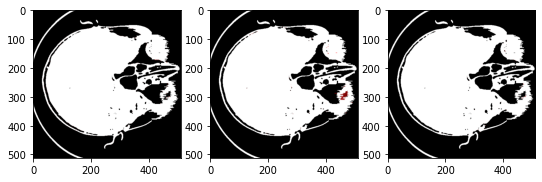

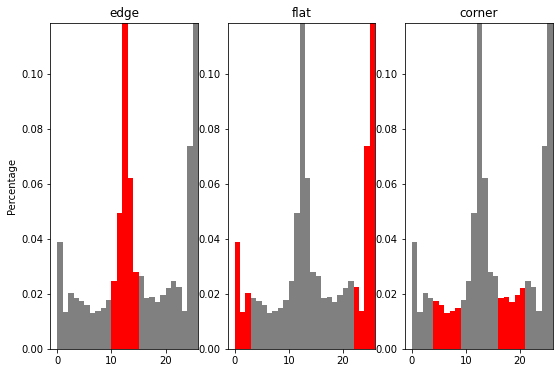

In [94]:
path_to_ct_scans = os.path.join(basePath, "ct_scans")

# hemorrhage
patient = 49
slice = 14
path_to_patient = os.path.join(path_to_ct_scans, f"0{patient}.nii")
image = nib.load(path_to_patient).get_fdata()
image_slice = image[:,:,slice-1]
print("Slice with hemorrhage")
LocalBinaryPattern(image_slice).plot_binary_ct_scan_with_LBP_mask()
LocalBinaryPattern(image_slice).plot_histogram()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Slice with no-hemorrhage


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


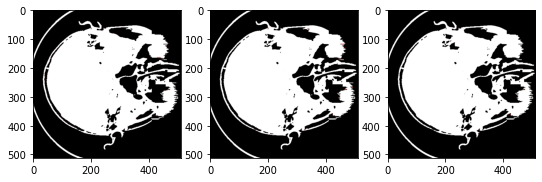

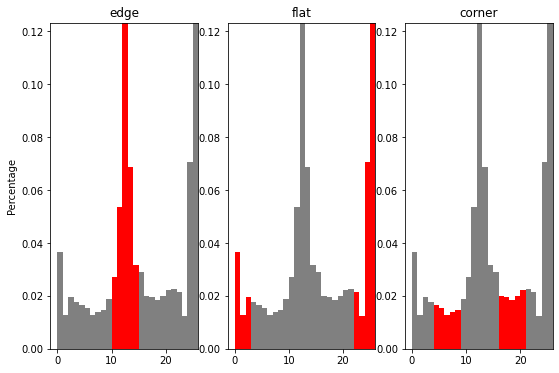

In [95]:
# no-hemorrhage
print("Slice with no-hemorrhage")
patient = 49
slice = 13
path_to_patient = os.path.join(path_to_ct_scans, f"0{patient}.nii")
image = nib.load(path_to_patient).get_fdata()
image_slice = image[:,:,slice-1]
LocalBinaryPattern(image_slice).plot_binary_ct_scan_with_LBP_mask()
LocalBinaryPattern(image_slice).plot_histogram()